In [1]:
import matplotlib.pyplot as plt
import lesion
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import unet
import residual_unet
import utils as util
import torch.nn.functional as F
from sklearn.metrics import jaccard_score as jsc
device = torch.device("cuda:0")
import ECE

In [2]:
class ToTensor_segmap(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, segmap):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # In this case, Channels is 1, so there is no need to swap since data is in HxW      
  
        segmap = np.array(segmap)
        return torch.from_numpy(segmap) / 255

image_transform = transforms.Compose([
        transforms.RandomGrayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
seg_transform = ToTensor_segmap()

In [3]:
batch_size = 2
dataset = lesion.LesionDataset("data",folder_name = 'test',joint_transform=False,img_transform=image_transform, seg_transform=seg_transform,verbose = True)
loader = DataLoader(dataset, batch_size=batch_size,shuffle=False, num_workers=4)

In [4]:
#M independetly trained models
model1 = torch.load("models/" + "gate_all.pth")
model2 =torch.load("models/" + "gate_all_1.pth")
model3 =torch.load("models/" + "gate_all_2.pth")
model4 =torch.load("models/" + "gate_all_3.pth")
model5 =torch.load("models/" + "gate_all_4.pth")

model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()


DataParallel(
  (module): res_unet_gate(
    (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout2d(p=0.3, inplace=False)
    (preprocess): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (down1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(


In [5]:
def apply_dropout(m):
    if type(m) == nn.Dropout2d:
        m.train()
        
#T is the number of times to sample to approximate the posterior predictive distribution
#Assume model in eval mode
#To perform deterministic ensemble, set probabilistic to False and T to 1

def pred_mean(loader,model,T, probabilistic = True):
    total = len(loader)*batch_size
    if(probabilistic):
        # if probabilistic turn on Dropout!
        print("Probabilistic Ensembling Mode")
        model.apply(apply_dropout)
    preds = np.zeros((total, 2, 512, 1024))
    var = np.zeros((total, 2, 512, 1024))
    targets = np.zeros((total, 512, 1024))
    for iteration in range(T):
        for i,data in enumerate(loader):
                image = data[0].to(device)
                output = model(image)
                segmap = data[1].numpy()
                preds[batch_size*i:batch_size*i + batch_size] += output.detach().cpu().numpy()
                if(iteration==0):
                    targets[batch_size*i:batch_size*i + batch_size] = segmap
    preds = preds / T
    return preds,targets
        
    

    
     
    

In [6]:
pred_temp = None

pred,targets = pred_mean(loader,model1,1,False)
pred_temp = pred


pred,_ = pred_mean(loader,model2,1,False)
pred_temp += pred


pred,_= pred_mean(loader,model3,1,False)
pred_temp += pred

pred,_ = pred_mean(loader,model4,1,False)
pred_temp += pred

pred,_= pred_mean(loader,model5,1,False)
pred_temp += pred

pred_temp/=5



In [10]:
pred = pred_temp.argmax(axis=1)

In [11]:

def get_score(pred,t):
    jaccard = 0
    total = len(loader)*batch_size
    for i in range(total):
        jaccard += jsc(pred[i].reshape(-1),t[i].reshape(-1))
    jaccard /= total
    
    return jaccard,np.count_nonzero(pred==t)/pred.reshape(-1).shape[0]
        

In [12]:
jaccard,accuracy =get_score(pred,targets)
print("Jaccard Score:{},  Accuracy:{} ".format(jaccard,accuracy))

Jaccard Score:0.7054300846227345,  Accuracy:0.9163725916544596 


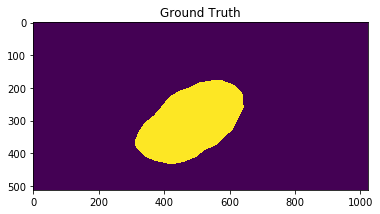

In [64]:
i=1
plt.title("Ground Truth")
plt.imshow(targets[i])


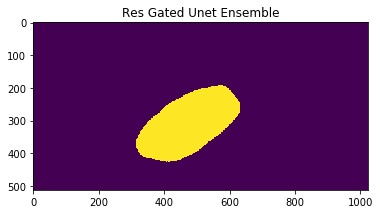

In [65]:
plt.title("Res Gated Unet Ensemble")
plt.imshow(pred[i])